In [1]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import measurement_analysis as ma
import pickle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "/Users/blazejmanczak/Desktop/Q1/DataChallenge3/"
flow_data_DRU, level_data_DRU = lf.get_measurements(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150")
rain_data = lf.get_rain(file_path +"/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

In [3]:
# Either run this cell or open pickle in the next one
df = ma.measurement_analysis(flow_data_DRU, level_data_DRU, rain_data, area_data=data.area_data,
                             village_code="DRU", dry_threshold = 2.5)

In [3]:
"""
#Save pickle
filename = 'ma_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()
"""

# open pickle
pickle_in = open("/Users/blazejmanczak/Desktop/Q1/DataChallenge3/ma_df", "rb")
df = pickle.load(pickle_in)

## Some exploration 

In [5]:
df.flow_data.set_index('TimeStamp', inplace= True, drop = False)
df.level_data.set_index('TimeStamp', inplace= True, drop = False)

In [6]:
# Only take dry days
df.level_data = df.level_data[df.level_data['Dry'] == 1]
df.flow_data = df.flow_data[df.flow_data['Dry'] == 1]

In [7]:
df.level_data["Minute"] = df.level_data["TimeStamp"].apply(lambda i: i.minute) # get the minute column
df.flow_data['Minute'] = df.flow_data['TimeStamp'].apply(lambda i: i.minute)

df.level_data["Second"] = df.level_data["TimeStamp"].apply(lambda i: i.second) # get the second column
df.flow_data['Second'] = df.flow_data['TimeStamp'].apply(lambda i: i.second)

In [8]:
df.level_data = df.level_data[df.level_data['DataQuality'] == 1]
df.flow_data = df.flow_data[df.flow_data['DataQuality'] == 1]

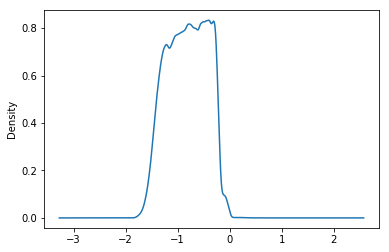

In [9]:
# Check for the  min and max "off" level - the level when the pump is not working
df.level_data['Value'].plot.kde()

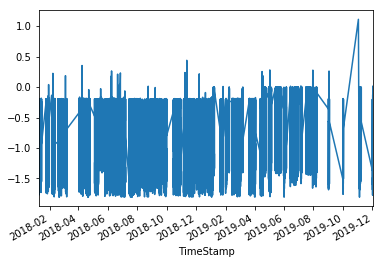

In [10]:
df.level_data['Value'].plot()

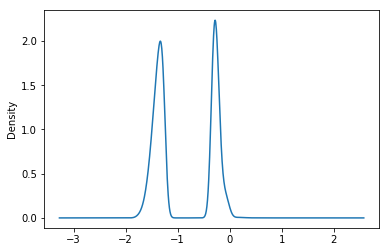

In [11]:
df.level_data[(df.level_data['Value'] < -1.25) | (df.level_data['Value'] > -0.35) ]['Value'].plot.kde()

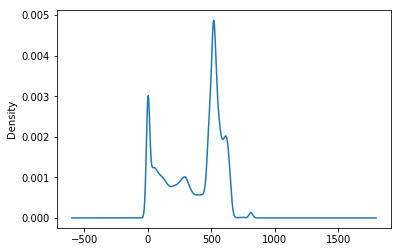

In [12]:
df.flow_data['Value'].plot.kde()

## Playground for investigaring weird cases

In [13]:
def take_neigbourhood(row, minute_interval = [0,1]):
    date = row['Date'][0]
    hour = int(row['Hour'])
    minute = int(row['Minute'])
    second = int(row['Second'])
    
    lev = df.level_data[(df.level_data['Date'] == date) & (df.level_data['Hour'] == hour)
                           & (df.level_data['Minute'] <= min(minute + minute_interval[1], 59)) 
                      & (df.level_data['Minute'] >= max(minute - minute_interval[0], 0))]
    fl = df.flow_data[(df.flow_data['Date'] == date) & (df.flow_data['Hour'] == hour)
                           & (df.flow_data['Minute'] <= min(minute + minute_interval[1], 59)) 
                      & (df.flow_data['Minute'] >= max(minute - minute_interval[0], 0))]
    return lev, fl

In [14]:
low_peaks = df.level_data[((df.level_data['min']) == 1) & (df.level_data['Value'] < -1)].iloc[71:73]
low_peaks # between these times 2 peaks have been identified

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Minute,Second
TimeStamp,,,,,,,,,,,,,,,,
2018-01-10 20:19:15,8150,2018-01-10 20:19:15,-1.412076,1,2018-01-10,20,1,0,15.0,0.066667,-0.036465,0,1,1,19,15
2018-01-10 20:42:55,8150,2018-01-10 20:42:55,-1.063882,1,2018-01-10,20,1,0,5.0,0.200000,-0.336414,0,1,1,42,55


In [15]:
high_peaks = df.level_data[((df.level_data['max']) == 1) & (df.level_data['Value'] > -0.5)].iloc[73:75]
high_peaks

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Minute,Second
TimeStamp,,,,,,,,,,,,,,,,
2018-01-10 20:33:15,8150,2018-01-10 20:33:15,-0.419240,1,2018-01-10,20,1,0,85.0,0.011765,0.051142,1,0,1,33,15
2018-01-10 20:36:35,8150,2018-01-10 20:36:35,-0.255961,1,2018-01-10,20,1,0,20.0,0.050000,0.039582,1,0,1,36,35


In [16]:
lev, fl = take_neigbourhood(high_peaks.iloc[[0]], minute_interval= [3,10])
lev

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Minute,Second
TimeStamp,,,,,,,,,,,,,,,,
2018-01-10 20:30:40,8150,2018-01-10 20:30:40,-0.521822,1,2018-01-10,20,1,0,65.0,0.015385,0.054112,0,0,1,30,40
2018-01-10 20:31:45,8150,2018-01-10 20:31:45,-0.472047,1,2018-01-10,20,1,0,65.0,0.015385,0.049775,0,0,1,31,45
2018-01-10 20:31:50,8150,2018-01-10 20:31:50,-0.470382,1,2018-01-10,20,1,0,5.0,0.200000,0.001666,0,0,1,31,50
2018-01-10 20:33:15,8150,2018-01-10 20:33:15,-0.419240,1,2018-01-10,20,1,0,85.0,0.011765,0.051142,1,0,1,33,15
2018-01-10 20:33:20,8150,2018-01-10 20:33:20,-0.420904,1,2018-01-10,20,1,0,5.0,0.200000,-0.001664,0,1,1,33,20
2018-01-10 20:34:00,8150,2018-01-10 20:34:00,-0.360029,1,2018-01-10,20,1,0,40.0,0.025000,0.060874,0,0,1,34,0
2018-01-10 20:35:10,8150,2018-01-10 20:35:10,-0.307091,1,2018-01-10,20,1,0,70.0,0.014286,0.052938,0,0,1,35,10
2018-01-10 20:36:35,8150,2018-01-10 20:36:35,-0.255961,1,2018-01-10,20,1,0,20.0,0.050000,0.039582,1,0,1,36,35
2018-01-10 20:37:00,8150,2018-01-10 20:37:00,-0.295544,1,2018-01-10,20,1,0,25.0,0.040000,-0.039582,0,1,1,37,0


In [17]:
fl

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Flow,max,min,Dry,Minute,Second
TimeStamp,,,,,,,,,,,,,,,,
2018-01-10 20:37:00,8150,2018-01-10 20:37:00,0.347213,1,2018-01-10,20,1,0,45.0,0.022222,0.004340,0,0,1,37,0
2018-01-10 20:38:40,8150,2018-01-10 20:38:40,0.347213,1,2018-01-10,20,1,0,45.0,0.022222,0.004340,0,0,1,38,40
2018-01-10 20:38:50,8150,2018-01-10 20:38:50,250.347200,1,2018-01-10,20,1,0,10.0,0.100000,0.695409,0,0,1,38,50
2018-01-10 20:38:55,8150,2018-01-10 20:38:55,280.347200,1,2018-01-10,20,1,0,5.0,0.200000,0.389371,1,0,1,38,55
2018-01-10 20:39:05,8150,2018-01-10 20:39:05,314.072800,1,2018-01-10,20,1,0,5.0,0.200000,0.436212,0,0,1,39,5
2018-01-10 20:39:10,8150,2018-01-10 20:39:10,339.899100,1,2018-01-10,20,1,0,5.0,0.200000,0.472082,0,0,1,39,10
2018-01-10 20:39:15,8150,2018-01-10 20:39:15,359.899100,1,2018-01-10,20,1,0,5.0,0.200000,0.499860,0,0,1,39,15
2018-01-10 20:39:20,8150,2018-01-10 20:39:20,379.899100,1,2018-01-10,20,1,0,5.0,0.200000,0.527638,0,0,1,39,20
2018-01-10 20:39:25,8150,2018-01-10 20:39:25,399.899100,1,2018-01-10,20,1,0,5.0,0.200000,0.555415,0,0,1,39,25


### Algorithm in words:
Find the local minimum of the level (the valley). Then find the next miniumum. Let the time between them be $t_{h}$.

Establish if you have a maximum of the level (the hill) between the two minimum. If not, abandon these points.
Assume that the pump works at constant flow **f** [m3/h].
Let the time between the maximum and the second of the two minima be denoted by $t_{f}$.

Then $$f \cdot t_{f}$$ tells us how much water came in time $t_{h}$.

In [18]:
high_peaks = df.level_data[((df.level_data['max']) == 1) & (df.level_data['Value'] > -0.4)]#.iloc[107:108]
low_peaks = df.level_data[((df.level_data['min']) == 1) & (df.level_data['Value'] < -1)]#.iloc[96:98]

In [19]:
high_peaks.reset_index(drop=True, inplace=True) # we want the index to be 0, 1, 2, ...
low_peaks.reset_index(drop = True, inplace=True)

high_peaks['Counter'] = range(len(high_peaks)) # useful trick for the apply function
low_peaks['Counter'] = range(len(low_peaks))

In [20]:
def find_max_in_between(time_stamp_start, time_stamp_end):
    """ Function that finds a row between two timestamps with a maxiumum in high peaks DataFrame"""
    
    result = high_peaks[(high_peaks['TimeStamp'] > time_stamp_start) &(high_peaks['TimeStamp'] < time_stamp_end)]
    if result.shape[0] > 1: # if more than one maxium found
        #print("Alert!", result.shape[0], "maximas found between:", time_stamp_start, "and", time_stamp_end)
        return result[result['Value'] == result['Value'].max()].iloc[[0]] # the row that has the biggest "Value"
    if result.shape[0] == 1:
        return result
    else:
        #print("No maxiumum found")
        return None

def connect_the_minima(row, last_row_index):
    """Determines the inflow in time interval t_h. Used in an pply function."""
    
    row_index = row['Counter'] # get the index of the current row
    if row_index < last_row_index: # we can't do anything about the last row
        next_row = low_peaks.loc[row_index + 1] 
        max_in_between = find_max_in_between(row['TimeStamp'], next_row['TimeStamp']) # it is a row or None
        #print((max_in_between))
        
        if max_in_between is not None: # if the maxiumum between the two minima can be found in high_peaks
            tf = ((next_row['TimeStamp'] - max_in_between['TimeStamp'])).apply(lambda i: i.seconds) / 3600 #converting to hours
            avg_flow = df.flow_data[(df.flow_data['TimeStamp'] > max_in_between['TimeStamp'].values[0]) & # take the flow measurements between the minimas 
                                   (df.flow_data['TimeStamp'] < next_row['TimeStamp'] )]
            # The follwoing if statement can be disabled for speed
            if avg_flow.shape[0]> 15: # if we have more than 15 observations for the flow, take the avg of the value column as f
                #print(np.mean(avg_flow['Value']))
                return float(tf * np.mean(avg_flow['Value'])) # 450 is by assumption the average flow between maxima and miniumum
            return float(tf * 450) # otherwise assume a constant
        else:
            return None

    else: # the last row
        return None
    

def chain_of_the_minima(low_peaks = low_peaks):
    lp = low_peaks.copy()
    lp['SewageInflow'] =  lp.apply(lambda row: connect_the_minima(row, len(lp) - 1) , axis = 1) # in m3 between the two minimas
    return lp
    
    

In [21]:
inflow_sewer = chain_of_the_minima(low_peaks)

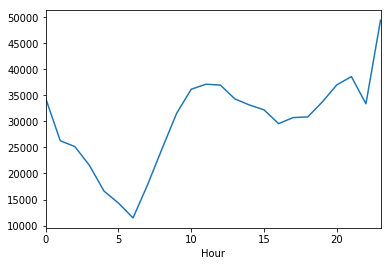

In [708]:
inflow_sewer.groupby('Hour')['SewageInflow'].sum().plot()

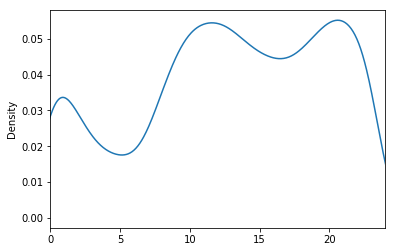

In [676]:
inflow_sewer['Hour'].plot.kde(xlim=[0,24]) # so we have more measurements (thus more inflow) in rush hours

The average hourly inflow must still be calculated (more measurements in peak hours).
Note that the value of the coulumn *SewageInflow* is connected to the timestamp of the next miniumum (so next row in low_peaks) data set.

In [682]:
# Example of how the find_max_in_between works
find_max_in_between(low_peaks.iloc[0]['TimeStamp'], low_peaks.iloc[1]['TimeStamp'])

,RG_ID,TimeStamp,Value,DataQuality,Date,Hour,Month,Weekend,TimeSpan,Freq,Delta,max,min,Dry,Minute,Second,Counter
1,8150,2018-01-09 01:14:35,-0.244581,1,2018-01-09,1,1,0,210.0,0.004762,0.050962,1,0,1,14,35,1


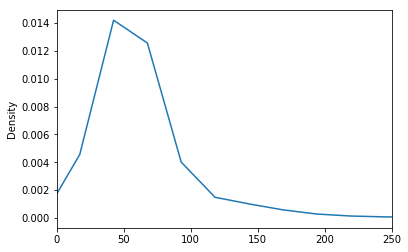

In [683]:
inflow_sewer['SewageInflow'].plot.kde(xlim = [0, 250])